In [1]:
!pip install ultralytics==8.3.124 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.8 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is

# Imports

In [2]:
import os
import glob
import yaml 
import random
import shutil
import torch 

import cv2
import numpy as np
import matplotlib.pyplot as plt

from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Constants

In [3]:
# --- Configuration ---
BASE_DATA_DIR = '/kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset'
ORIGINAL_DATA_DIR = os.path.join(BASE_DATA_DIR, 'Original_Data')
AUGMENTED_DATA_DIR = os.path.join(BASE_DATA_DIR, 'Augmented_Data')

# Define paths for augmented data splits
TRAIN_IMG_DIR = os.path.join(AUGMENTED_DATA_DIR, 'train', 'images')
TRAIN_LBL_DIR = os.path.join(AUGMENTED_DATA_DIR, 'train', 'labels')
VALID_IMG_DIR = os.path.join(AUGMENTED_DATA_DIR, 'valid', 'images')
VALID_LBL_DIR = os.path.join(AUGMENTED_DATA_DIR, 'valid', 'labels')
TEST_IMG_DIR = os.path.join(AUGMENTED_DATA_DIR, 'test', 'images')
TEST_LBL_DIR = os.path.join(AUGMENTED_DATA_DIR, 'test', 'labels')

# Class names corresponding to IDs 0-5
class_names = ['Caries', 'Infection', 'Impacted Teeth', 'Fractured Teeth', 'Broken Crown', 'Healthy']
num_classes = len(class_names)

# Using relative paths makes the yaml file more portable
INPUT_DATA_DIR = '/kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data'
TRAIN_IMG_DIR_REL = os.path.join(INPUT_DATA_DIR, 'train', 'images')
VALID_IMG_DIR_REL = os.path.join(INPUT_DATA_DIR, 'valid', 'images')
TEST_IMG_DIR_REL = os.path.join(INPUT_DATA_DIR, 'test', 'images')

# Output directory for the yaml file (in the working directory)
YAML_DIR = '/kaggle/working/'
yaml_file_path = os.path.join(YAML_DIR, 'dental_opg_dataset.yaml')

# Step1: Verify Folder Structure

In [4]:
def check_and_count_files(dir_path, extensions=['.jpg', '.txt', '.json']):
    """Checks if a directory exists and counts files with given extensions."""
    if not os.path.isdir(dir_path):
        print(f"Directory NOT FOUND: {dir_path}")
        return None
    
    counts = {ext: 0 for ext in extensions}
    all_files = glob.glob(os.path.join(dir_path, '*'))
    
    for f in all_files:
        for ext in extensions:
            if f.lower().endswith(ext):
                counts[ext] += 1
                break # Count each file only once based on the first matching extension
                
    count_str = ", ".join([f"{count} {ext}" for ext, count in counts.items() if count > 0])
    print(f"Found: {dir_path} - Contains: {count_str if count_str else '0 files specified'}")
    return counts

# Check Original Data
print("\n[Original Data]")
# Note: Original data description mentions .json labels, but the folder structure implies .txt. Let's check both.
# Correction based on user prompt: Original_Data also has .txt labels.
original_img_files = glob.glob(os.path.join(ORIGINAL_DATA_DIR, '*.jpg'))
original_lbl_files = glob.glob(os.path.join(ORIGINAL_DATA_DIR, '*.txt'))
print(f"Found: {ORIGINAL_DATA_DIR}")
print(f"  - Images (.jpg): {len(original_img_files)}")
print(f"  - Labels (.txt): {len(original_lbl_files)}")
# If JSON exists, check them too:
original_json_files = glob.glob(os.path.join(ORIGINAL_DATA_DIR, '*.json'))
if original_json_files:
    print(f"  - Labels (.json): {len(original_json_files)}")


# Check Augmented Data
print("\n[Augmented Data]")
train_img_count = len(glob.glob(os.path.join(TRAIN_IMG_DIR, '*.jpg')))
train_lbl_count = len(glob.glob(os.path.join(TRAIN_LBL_DIR, '*.txt')))
valid_img_count = len(glob.glob(os.path.join(VALID_IMG_DIR, '*.jpg')))
valid_lbl_count = len(glob.glob(os.path.join(VALID_LBL_DIR, '*.txt')))
test_img_count = len(glob.glob(os.path.join(TEST_IMG_DIR, '*.jpg')))
test_lbl_count = len(glob.glob(os.path.join(TEST_LBL_DIR, '*.txt')))

print(f"Train: Images={train_img_count}, Labels={train_lbl_count}")
print(f"Valid: Images={valid_img_count}, Labels={valid_lbl_count}")
print(f"Test:  Images={test_img_count}, Labels={test_lbl_count}")

# Basic consistency check
if train_img_count != train_lbl_count or valid_img_count != valid_lbl_count or test_img_count != test_lbl_count:
    print("\n*** WARNING: Mismatch between image and label counts in augmented data splits! ***")
else:
    print("\nImage and label counts match in augmented data splits.")


[Original Data]
Found: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Original_Data
  - Images (.jpg): 232
  - Labels (.txt): 232

[Augmented Data]
Train: Images=567, Labels=558
Valid: Images=23, Labels=23
Test:  Images=23, Labels=23

*** WARNING: Mismatch between image and label counts in augmented data splits! ***


## Step 2: Examine Label Format (YOLO Detection)

In [5]:
def examine_label_file_detection(label_path):
    """Reads a YOLO detection label file and prints its format info."""
    print(f"\nExamining: {label_path}")
    if not os.path.exists(label_path):
        print("File not found.")
        return None

    lines_info = []
    try:
        with open(label_path, 'r') as f:
            lines = f.readlines()

        if not lines:
            print("Label file is empty.")
            return []

        print(f"Number of bounding boxes (lines): {len(lines)}")

        for i, line in enumerate(lines):
            parts = line.strip().split()
            if len(parts) != 5: # Expecting class_id cx cy w h
                 print(f"  - Line {i+1}: Invalid format - expected 5 parts, found {len(parts)}. Content: '{line.strip()}'")
                 lines_info.append({'valid': False, 'parts': len(parts), 'content': line.strip()})
                 continue

            try:
                class_id = int(parts[0])
                cx = float(parts[1])
                cy = float(parts[2])
                w = float(parts[3])
                h = float(parts[4])
                coords = np.array([cx, cy, w, h])

                if not np.all((coords >= 0.0) & (coords <= 1.0)):
                    print(f"  - Line {i+1}: Invalid format - coordinates or dimensions out of [0, 1] range. Class: {class_id}, Values: {coords}")
                    lines_info.append({'valid': False, 'class': class_id, 'coords': coords.tolist(), 'content': line.strip()})
                else:
                    info = {'valid': True, 'class': class_id, 'cx': cx, 'cy': cy, 'w': w, 'h': h}
                    lines_info.append(info)
                    if i < 5: # Print details only for the first few lines
                         print(f"  - Line {i+1}: Class={class_id}, CenterX={cx:.4f}, CenterY={cy:.4f}, Width={w:.4f}, Height={h:.4f}")

            except ValueError:
                 print(f"  - Line {i+1}: Invalid format - non-numeric values found. Content: '{line.strip()}'")
                 lines_info.append({'valid': False, 'content': line.strip()})

    except Exception as e:
        print(f"Error reading or parsing {label_path}: {e}")
        return None

    return lines_info

# Examine one label file from the training set
sample_label_files = glob.glob(os.path.join(TRAIN_LBL_DIR, '*.txt'))
if sample_label_files:
    examine_label_file_detection(random.choice(sample_label_files))
else:
    print("No label files found in training set to examine.")


Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/train/labels/187_jpg.rf.d083a459263bb5df9f6c9d5a3e70ffd8.txt
Number of bounding boxes (lines): 15
  - Line 1: Class=2, CenterX=0.4953, CenterY=0.0583, Width=0.0875, Height=0.1167
  - Line 2: Class=5, CenterX=0.2047, CenterY=0.0847, Width=0.0625, Height=0.1694
  - Line 3: Class=5, CenterX=0.4078, CenterY=0.0708, Width=0.0875, Height=0.1417
  - Line 4: Class=0, CenterX=0.7227, CenterY=0.3264, Width=0.0766, Height=0.1472
  - Line 5: Class=5, CenterX=0.6664, CenterY=0.3208, Width=0.0766, Height=0.1583


## Step 3: Visualize Sample Images and Bounding Boxes


--- Visualizing Training Samples ---

Visualizing: 65_jpg.rf.fb1bc85b189f4c340dd47d3871e666f1.jpg
Image dimensions (HxW): 295 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/train/labels/65_jpg.rf.fb1bc85b189f4c340dd47d3871e666f1.txt
Number of bounding boxes (lines): 5
  - Line 1: Class=5, CenterX=0.4125, CenterY=0.6780, Width=0.0422, Height=0.2780
  - Line 2: Class=5, CenterX=0.6109, CenterY=0.6780, Width=0.0656, Height=0.2881
  - Line 3: Class=0, CenterX=0.8109, CenterY=0.5661, Width=0.0984, Height=0.1831
  - Line 4: Class=5, CenterX=0.7016, CenterY=0.3492, Width=0.0641, Height=0.2576
  - Line 5: Class=0, CenterX=0.2250, CenterY=0.5729, Width=0.0781, Height=0.1525
Drawn 5 bounding boxes.


/tmp/ipykernel_31/936133588.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('hsv', len(unique_classes) if unique_classes else 1)


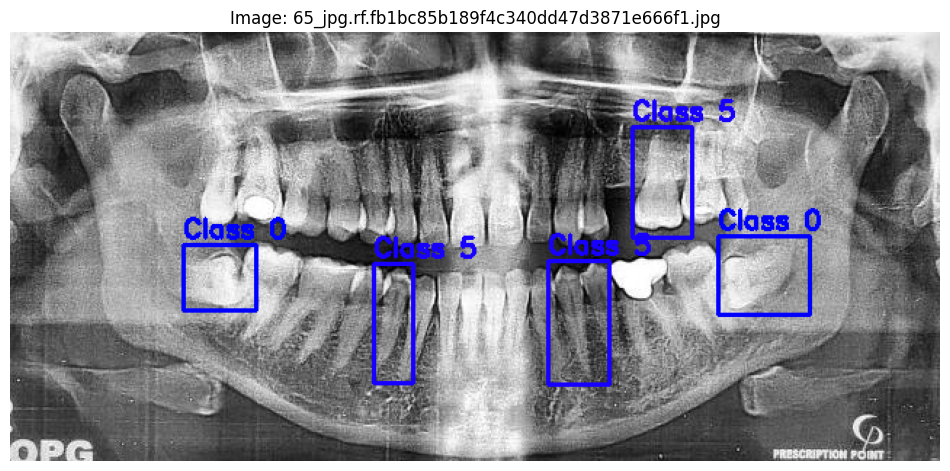


Visualizing: 83_jpg.rf.9439ee4bc6faebfb6d5e36db2cc05a04.jpg
Image dimensions (HxW): 373 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/train/labels/83_jpg.rf.9439ee4bc6faebfb6d5e36db2cc05a04.txt
Number of bounding boxes (lines): 7
  - Line 1: Class=5, CenterX=0.1208, CenterY=0.2205, Width=0.0902, Height=0.2465
  - Line 2: Class=2, CenterX=0.3820, CenterY=0.3060, Width=0.1264, Height=0.1940
  - Line 3: Class=5, CenterX=0.9531, CenterY=0.3727, Width=0.0938, Height=0.2359
  - Line 4: Class=2, CenterX=0.7154, CenterY=0.3907, Width=0.1147, Height=0.2258
  - Line 5: Class=0, CenterX=0.2586, CenterY=0.8585, Width=0.1057, Height=0.2416
Drawn 7 bounding boxes.


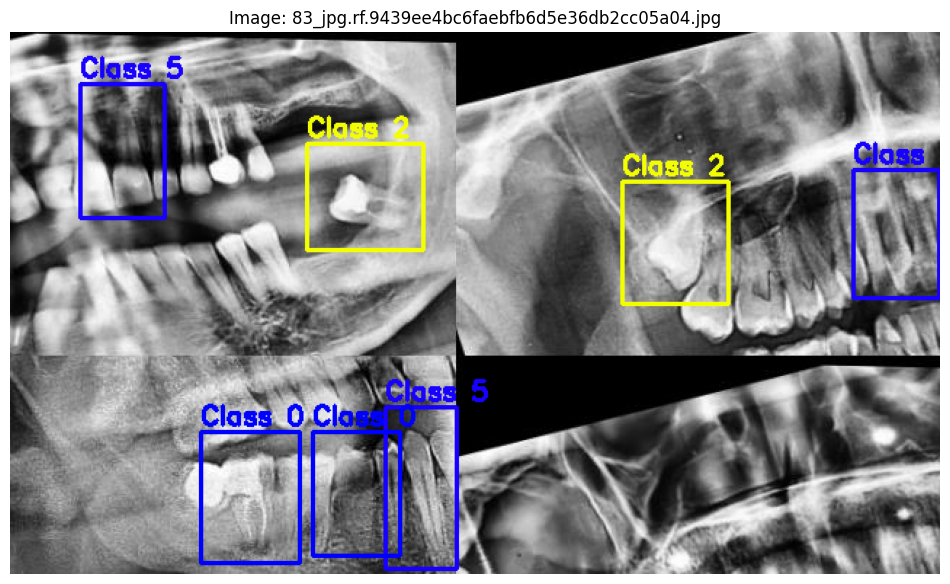


--- Visualizing Validation Samples ---

Visualizing: 231_jpg.rf.adc4c01feb3e4abf314a91641b08c92f.jpg
Image dimensions (HxW): 310 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/valid/labels/231_jpg.rf.adc4c01feb3e4abf314a91641b08c92f.txt
Number of bounding boxes (lines): 5
  - Line 1: Class=5, CenterX=0.5266, CenterY=0.4806, Width=0.0453, Height=0.2710
  - Line 2: Class=5, CenterX=0.2516, CenterY=0.3871, Width=0.0594, Height=0.2419
  - Line 3: Class=5, CenterX=0.3031, CenterY=0.6968, Width=0.1094, Height=0.2968
  - Line 4: Class=5, CenterX=0.7922, CenterY=0.3871, Width=0.0437, Height=0.2387
  - Line 5: Class=5, CenterX=0.6531, CenterY=0.7323, Width=0.0672, Height=0.2484
Drawn 5 bounding boxes.


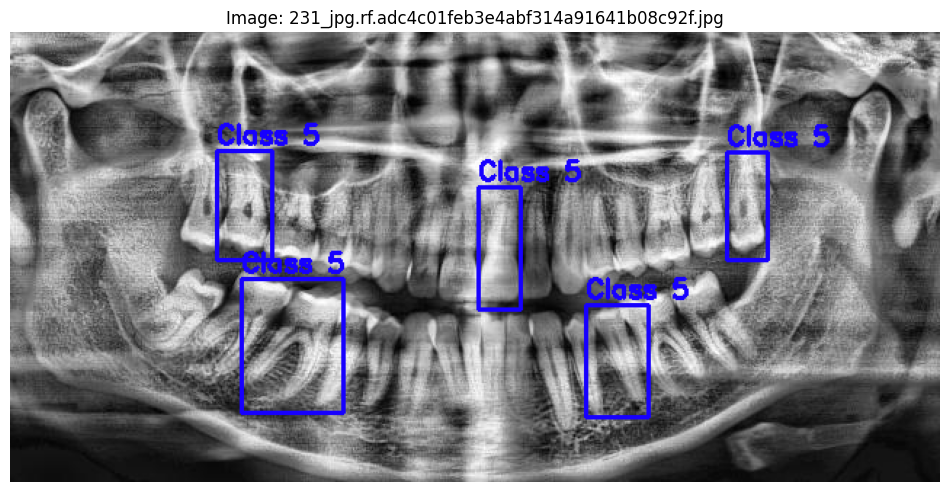


Visualizing: 73_jpg.rf.327383b373576febaed8bf0777c8d0fc.jpg
Image dimensions (HxW): 295 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/valid/labels/73_jpg.rf.327383b373576febaed8bf0777c8d0fc.txt
Number of bounding boxes (lines): 3
  - Line 1: Class=4, CenterX=0.4344, CenterY=0.6407, Width=0.0547, Height=0.2915
  - Line 2: Class=4, CenterX=0.5656, CenterY=0.6068, Width=0.0375, Height=0.2339
  - Line 3: Class=3, CenterX=0.8063, CenterY=0.5085, Width=0.0719, Height=0.2508
Drawn 3 bounding boxes.


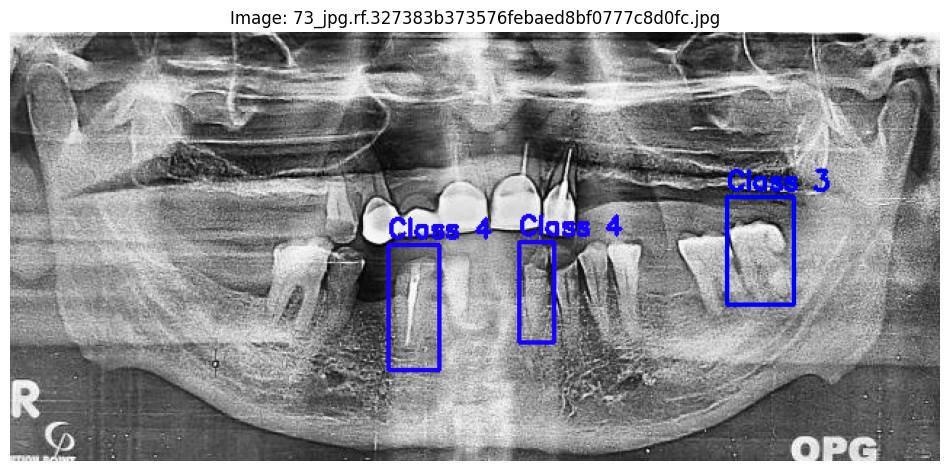


--- Visualizing Test Samples ---

Visualizing: 160_jpg.rf.32ce857ccfe7859a4adc71a6ce2d40e1.jpg
Image dimensions (HxW): 271 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/test/labels/160_jpg.rf.32ce857ccfe7859a4adc71a6ce2d40e1.txt
Number of bounding boxes (lines): 6
  - Line 1: Class=0, CenterX=0.7250, CenterY=0.3358, Width=0.0625, Height=0.2583
  - Line 2: Class=5, CenterX=0.4953, CenterY=0.3653, Width=0.0656, Height=0.2804
  - Line 3: Class=5, CenterX=0.3031, CenterY=0.3764, Width=0.0688, Height=0.2768
  - Line 4: Class=0, CenterX=0.7719, CenterY=0.3284, Width=0.0625, Height=0.2841
  - Line 5: Class=0, CenterX=0.3141, CenterY=0.6568, Width=0.0609, Height=0.2472
Drawn 6 bounding boxes.


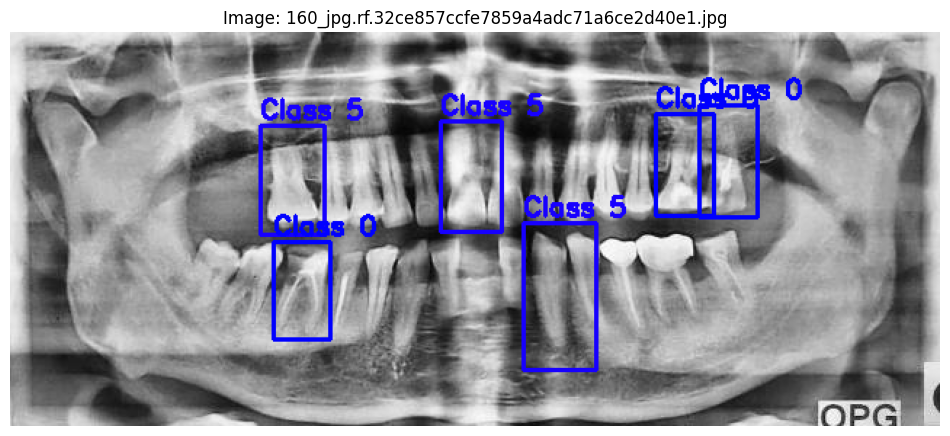


Visualizing: 146_jpg.rf.416fe5cb77bd045aedfc942be5392ff6.jpg
Image dimensions (HxW): 301 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/test/labels/146_jpg.rf.416fe5cb77bd045aedfc942be5392ff6.txt
Number of bounding boxes (lines): 3
  - Line 1: Class=5, CenterX=0.7937, CenterY=0.5914, Width=0.0859, Height=0.2425
  - Line 2: Class=0, CenterX=0.2703, CenterY=0.3090, Width=0.0625, Height=0.2957
  - Line 3: Class=0, CenterX=0.2250, CenterY=0.3189, Width=0.0625, Height=0.2193
Drawn 3 bounding boxes.


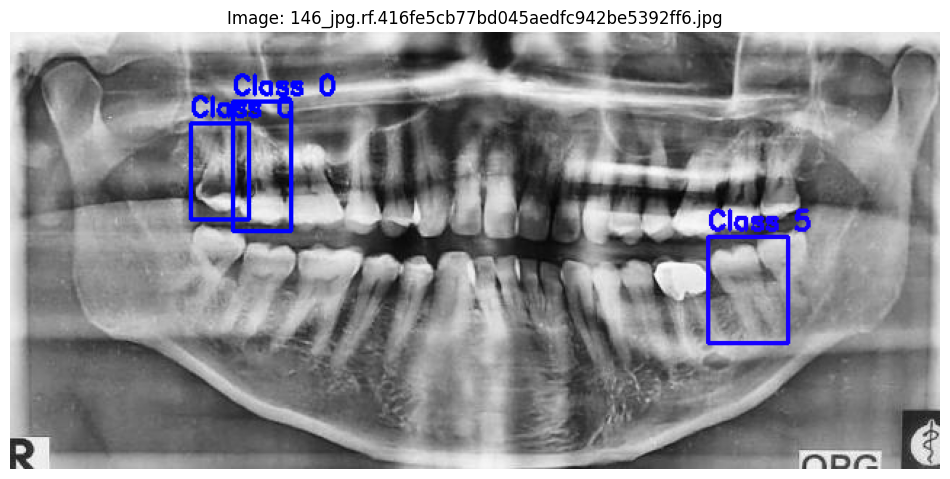

In [6]:
def display_image_with_boxes(image_path, label_path, num_samples=1):
    """Loads an image and its corresponding YOLO detection label, then displays them."""
    if not os.path.exists(image_path):
        print(f"Image file not found: {image_path}")
        return
    if not os.path.exists(label_path):
        print(f"Label file not found: {label_path}")
        # Optionally display the image without boxes if label is missing
        # img = cv2.imread(image_path)
        # if img is not None:
        #     plt.figure(figsize=(10, 7))
        #     plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        #     plt.title(f"Image: {os.path.basename(image_path)} (No Label Found)")
        #     plt.axis('off')
        #     plt.show()
        return

    img = cv2.imread(image_path)
    if img is None:
        print(f"Could not read image: {image_path}")
        return

    img_h, img_w = img.shape[:2]
    img_display = img.copy() # Work on a copy

    print(f"\nVisualizing: {os.path.basename(image_path)}")
    print(f"Image dimensions (HxW): {img_h} x {img_w}")

    lines_info = examine_label_file_detection(label_path) # Use updated examination function

    if lines_info is None or not lines_info:
        print("No valid bounding boxes found or error reading label file.")
    else:
        # Generate distinct colors for classes
        valid_classes = [info['class'] for info in lines_info if info['valid']]
        unique_classes = sorted(list(set(valid_classes))) if valid_classes else []
        # Use a colormap suitable for potentially many classes
        colors = plt.cm.get_cmap('hsv', len(unique_classes) if unique_classes else 1)
        class_colors = {cls: tuple(int(c*255) for c in colors(i)[:3]) for i, cls in enumerate(unique_classes)} # BGR for OpenCV

        box_count = 0
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5: continue # Skip invalid lines

                try:
                    class_id = int(parts[0])
                    cx = float(parts[1])
                    cy = float(parts[2])
                    w = float(parts[3])
                    h = float(parts[4])

                    # Denormalize coordinates and dimensions
                    center_x_abs = cx * img_w
                    center_y_abs = cy * img_h
                    box_w_abs = w * img_w
                    box_h_abs = h * img_h

                    # Calculate top-left (x1, y1) and bottom-right (x2, y2) coordinates
                    x1 = int(center_x_abs - box_w_abs / 2)
                    y1 = int(center_y_abs - box_h_abs / 2)
                    x2 = int(center_x_abs + box_w_abs / 2)
                    y2 = int(center_y_abs + box_h_abs / 2)

                    # Ensure coordinates are within image bounds (important for drawing)
                    x1 = max(0, x1)
                    y1 = max(0, y1)
                    x2 = min(img_w - 1, x2)
                    y2 = min(img_h - 1, y2)

                    color = class_colors.get(class_id, (0, 0, 255)) # Default to red if class not found
                    label_text = f"Class {class_id}" # You might want to map this to actual names later

                    # Draw the bounding box rectangle
                    cv2.rectangle(img_display, (x1, y1), (x2, y2), color, thickness=2)
                    # Add class label text above the box
                    cv2.putText(img_display, label_text, (x1, y1 - 5 if y1 > 10 else y1 + 15),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

                    box_count += 1

                except Exception as e:
                    print(f"Error processing line for drawing: {line.strip()} - {e}")
        print(f"Drawn {box_count} bounding boxes.")


    # Display using Matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)) # Convert BGR to RGB for plt
    plt.title(f"Image: {os.path.basename(image_path)}")
    plt.axis('off')
    plt.show()

# Get lists of files (Keep as before)
train_image_files = sorted(glob.glob(os.path.join(TRAIN_IMG_DIR, '*.jpg')))
valid_image_files = sorted(glob.glob(os.path.join(VALID_IMG_DIR, '*.jpg')))
test_image_files = sorted(glob.glob(os.path.join(TEST_IMG_DIR, '*.jpg')))

# Visualize a few samples from each split (Use updated function name)
num_samples_to_show = 2

print("\n--- Visualizing Training Samples ---")
for i in range(min(num_samples_to_show, len(train_image_files))):
    idx = random.randint(0, len(train_image_files)-1) # Pick random samples
    img_file = train_image_files[idx]
    lbl_file = os.path.join(TRAIN_LBL_DIR, os.path.basename(img_file).replace('.jpg', '.txt'))
    display_image_with_boxes(img_file, lbl_file) # Use updated function

print("\n--- Visualizing Validation Samples ---")
for i in range(min(num_samples_to_show, len(valid_image_files))):
    idx = random.randint(0, len(valid_image_files)-1)
    img_file = valid_image_files[idx]
    lbl_file = os.path.join(VALID_LBL_DIR, os.path.basename(img_file).replace('.jpg', '.txt'))
    display_image_with_boxes(img_file, lbl_file) # Use updated function

print("\n--- Visualizing Test Samples ---")
for i in range(min(num_samples_to_show, len(test_image_files))):
    idx = random.randint(0, len(test_image_files)-1)
    img_file = test_image_files[idx]
    lbl_file = os.path.join(TEST_LBL_DIR, os.path.basename(img_file).replace('.jpg', '.txt'))
    display_image_with_boxes(img_file, lbl_file) # Use updated function



## Step 4: Basic Statistics

In [7]:
image_widths = []
image_heights = []
boxes_per_image = [] # Changed name from segments_per_image
all_class_ids = set()
empty_label_files = 0

train_label_files = sorted(glob.glob(os.path.join(TRAIN_LBL_DIR, '*.txt')))

for lbl_file in train_label_files:
    img_file = os.path.join(TRAIN_IMG_DIR, os.path.basename(lbl_file).replace('.txt', '.jpg'))

    if not os.path.exists(img_file):
        print(f"Warning: Corresponding image not found for label {lbl_file}")
        continue

    # Image dimensions (Keep as before)
    try:
        # Optimization: Use cv2.imread only once if needed for both stats and visualization later
        # Or use a library like PIL to get dimensions without loading the full image if memory is a concern
        img = cv2.imread(img_file)
        if img is not None:
            h, w = img.shape[:2]
            image_heights.append(h)
            image_widths.append(w)
        else:
            print(f"Warning: Could not read image {img_file}")
            continue
    except Exception as e:
        print(f"Error reading image {img_file}: {e}")
        continue

    # Label info (Logic adapted for detection format)
    try:
        with open(lbl_file, 'r') as f:
            lines = f.readlines()

        num_boxes = 0
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 5: # Check for valid detection line format
                num_boxes += 1
                try:
                    all_class_ids.add(int(parts[0]))
                except ValueError:
                    print(f"Warning: Non-integer class ID found in {lbl_file}: {parts[0]}")
            elif parts: # If line is not empty but has wrong format
                 print(f"Warning: Invalid line format in {lbl_file}: '{line.strip()}'")


        boxes_per_image.append(num_boxes)

        if num_boxes == 0 and lines: # Label file exists but has no valid lines or is empty
             print(f"Warning: Label file {lbl_file} seems empty or contains only invalid lines.")
             if not lines:
                 empty_label_files += 1 # Count files that are truly empty


    except Exception as e:
        print(f"Error reading or processing label file {lbl_file}: {e}")

# Summary (Keep variable names consistent)
print(f"\nStatistics based on {len(train_label_files)} training labels:")
if image_widths:
    print(f"Image Widths: Min={np.min(image_widths)}, Max={np.max(image_widths)}, Avg={np.mean(image_widths):.2f}")
    print(f"Image Heights: Min={np.min(image_heights)}, Max={np.max(image_heights)}, Avg={np.mean(image_heights):.2f}")
    # Consider plotting histograms if needed
    # plt.figure(figsize=(10, 4))
    # plt.subplot(1, 2, 1)
    # plt.hist(image_widths, bins=20)
    # plt.title('Image Width Distribution (Train)')
    # plt.subplot(1, 2, 2)
    # plt.hist(image_heights, bins=20)
    # plt.title('Image Height Distribution (Train)')
    # plt.tight_layout()
    # plt.show()

if boxes_per_image:
    print(f"Bounding Boxes per Image: Min={np.min(boxes_per_image)}, Max={np.max(boxes_per_image)}, Avg={np.mean(boxes_per_image):.2f}")
    print(f"Number of completely empty label files: {empty_label_files}") # Clarified meaning
    # Consider plotting histogram
    # plt.figure(figsize=(6, 4))
    # plt.hist(boxes_per_image, bins=max(10, np.max(boxes_per_image) // 2 if np.max(boxes_per_image) > 0 else 10)) # Adjust bins
    # plt.title('Boxes per Image Distribution (Train)')
    # plt.show()

print(f"Unique Class IDs found: {sorted(list(all_class_ids))}")
if len(all_class_ids) > 0:
    print(f"This confirms a detection task with {len(all_class_ids)} classes.")
    print("You will need to define the names for these classes in your dataset.yaml file.")
else:
     print("Warning: No valid class IDs were found in the training labels.")




Statistics based on 558 training labels:
Image Widths: Min=639, Max=640, Avg=639.99
Image Heights: Min=250, Max=485, Avg=349.64
Bounding Boxes per Image: Min=1, Max=25, Avg=10.11
Number of completely empty label files: 0
Unique Class IDs found: [0, 1, 2, 3, 4, 5]
This confirms a detection task with 6 classes.
You will need to define the names for these classes in your dataset.yaml file.


## Step 5: Create Dataset.yaml File

In [8]:
dataset_yaml_content = f"""
path: {os.path.abspath(INPUT_DATA_DIR)} # Absolute path can sometimes be more reliable inside the library
train: {os.path.abspath(TRAIN_IMG_DIR_REL)} # Path to train images
val: {os.path.abspath(VALID_IMG_DIR_REL)}   # Path to validation images
test: {os.path.abspath(TEST_IMG_DIR_REL)}  # Path to test images (optional)

# Classes
nc: {num_classes}
names: {class_names}
"""

# Write the content to the YAML file
os.makedirs(YAML_DIR, exist_ok=True) # Ensure the directory exists
with open(yaml_file_path, 'w') as f:
    f.write(dataset_yaml_content)

print(f"--- dataset.yaml created at: {yaml_file_path} ---")
print("Content:")
print(dataset_yaml_content)
print("-" * 30)

--- dataset.yaml created at: /kaggle/working/dental_opg_dataset.yaml ---
Content:

path: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data # Absolute path can sometimes be more reliable inside the library
train: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/train/images # Path to train images
val: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/valid/images   # Path to validation images
test: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/test/images  # Path to test images (optional)

# Classes
nc: 6
names: ['Caries', 'Infection', 'Impacted Teeth', 'Fractured Teeth', 'Broken Crown', 'Healthy']

------------------------------


## Step 6: Configure Training Parameters

In [9]:
model_name = 'yolov10n.pt'

# Training hyperparameters
EPOCHS = 300  # Start with a reasonable number, can adjust based on val performance
IMG_SIZE = 640 # Input images will be resized to this (common default, matches data width)
BATCH_SIZE = 92 # Adjust based on GPU memory (16 is usually okay for T4/P100 with yolov8m)
PATIENCE = 50 # Early stopping patience: stops training if no improvement after 'patience' epochs
PROJECT_NAME = 'Dental_OPG_Detection' # Directory to save runs
RUN_NAME = f"yolov10n_e{EPOCHS}_batch{BATCH_SIZE}" # Specific name for this training run

# Check for GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cpu':
    print("WARNING: Training on CPU will be very slow. Ensure GPU is enabled in Kaggle settings.")
    # Consider reducing batch size or using a smaller model (yolov8n) if stuck on CPU
    # BATCH_SIZE = max(2, BATCH_SIZE // 4) # Example adjustment for CPU

Using device: cuda


In [10]:
RUN_NAME

'yolov10n_e300_batch92'

## Step 7: Initialize and Train the Model

In [11]:
print(f"\n--- Initializing YOLO model: {model_name} ---")
model = YOLO(model_name)

print(f"\n--- Starting Training ---")
print(f"   Data YAML: {yaml_file_path}")
print(f"   Epochs: {EPOCHS}")
print(f"   Image Size: {IMG_SIZE}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Patience: {PATIENCE}")
print(f"   Project: {PROJECT_NAME}")
print(f"   Run Name: {RUN_NAME}")
print("-" * 30)


--- Initializing YOLO model: yolov10n.pt ---


100%|██████████| 5.59M/5.59M [00:00<00:00, 113MB/s]


--- Starting Training ---
   Data YAML: /kaggle/working/dental_opg_dataset.yaml
   Epochs: 300
   Image Size: 640
   Batch Size: 92
   Patience: 50
   Project: Dental_OPG_Detection
   Run Name: yolov10n_e300_batch92
------------------------------


In [12]:
# Start training
try:
    results = model.train(
        data=yaml_file_path,
        epochs=EPOCHS,
        imgsz=IMG_SIZE,
        batch=BATCH_SIZE,
        patience=PATIENCE,
        device=device,          # Explicitly set device
        project=PROJECT_NAME,   # Saves runs to /kaggle/working/Dental_OPG_Detection/
        name=RUN_NAME,          # Subdirectory name within the project folder
        exist_ok=False,         # Set to True if you want to overwrite previous runs with the same name
        # Augmentation parameters can be adjusted here if needed, defaults are usually good.
        # e.g., degrees=10, translate=0.1, scale=0.1, flipud=0.5 ...
        cache=True, # Cache images in RAM for faster training (if RAM allows)
    )
    print("\n--- Training Completed Successfully ---")

except Exception as e:
    print(f"\n--- Training Interrupted/Failed ---")
    print(f"Error: {e}")

New https://pypi.org/project/ultralytics/8.3.125 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.124 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov10n.pt, data=/kaggle/working/dental_opg_dataset.yaml, epochs=300, time=None, patience=50, batch=92, imgsz=640, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=Dental_OPG_Detection, name=yolov10n_e300_batch92, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fal

100%|██████████| 755k/755k [00:00<00:00, 28.9MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1      9856  ultralytics.nn.modules.block.SCDown          [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1     36096  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 93.4MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.4±0.2 ms, read: 85.2±14.8 MB/s, size: 44.8 KB)


train: Scanning /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/train/labels... 558 images, 9 backgrounds, 0 corrupt: 100%|██████████| 567/567 [00:00<00:00, 928.11it/s]

WARNING ⚠️ train: Cache directory /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/train is not writeable, cache not saved.


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.4GB RAM): 100%|██████████| 567/567 [00:00<00:00, 868.86it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 11.4±3.1 MB/s, size: 48.0 KB)


val: Scanning /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/valid/labels... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<00:00, 340.81it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/valid is not writeable, cache not saved.
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.0GB RAM): 100%|██████████| 23/23 [00:00<00:00, 557.22it/s]


Plotting labels to Dental_OPG_Detection/yolov10n_e300_batch92/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.00071875), 107 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to Dental_OPG_Detection/yolov10n_e300_batch92
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      15.5G      4.978      9.431      4.122        230        640: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

                   all         23        115          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      15.1G      4.517      9.277      3.742        236        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]

                   all         23        115          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      15.3G      3.566      8.428      2.762        292        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]

                   all         23        115    0.00701      0.144    0.00936    0.00297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      15.2G      3.405      7.795      2.567       1500        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.15s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


      4/300      15.2G      3.394      7.668      2.561        264        640: 100%|██████████| 7/7 [00:10<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         23        115    0.00766      0.315     0.0168    0.00603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      15.4G      3.312      7.067      2.526        238        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

                   all         23        115    0.00776      0.396     0.0231    0.00856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      15.2G      3.328      6.589      2.484       1811        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.14s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


      6/300      15.2G      3.296       6.49      2.473        279        640: 100%|██████████| 7/7 [00:11<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all         23        115    0.00865      0.459     0.0788      0.033



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      15.5G      3.364       6.14      2.547        209        640: 100%|██████████| 7/7 [00:07<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all         23        115    0.00839      0.473     0.0825     0.0324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      15.4G      3.246      5.905        2.5        253        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]

                   all         23        115     0.0093       0.55      0.104     0.0514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      15.1G      3.219      5.623      2.476       1775        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.14s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


      9/300      15.1G      3.222      5.587      2.476        244        640: 100%|██████████| 7/7 [00:10<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all         23        115     0.0147      0.623      0.131     0.0684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      15.3G      3.184      5.372      2.463        264        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         23        115     0.0224      0.529      0.118      0.056



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      15.2G      3.221      5.386      2.458       1536        640:  14%|█▍        | 1/7 [00:01<00:06,  1.16s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     11/300      15.2G       3.14      5.327      2.454        269        640: 100%|██████████| 7/7 [00:11<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

                   all         23        115     0.0198      0.537      0.116     0.0629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      14.5G       3.06      5.151       2.45       1582        640:  43%|████▎     | 3/7 [00:03<00:04,  1.20s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     12/300      15.1G      3.102      5.097      2.436        203        640: 100%|██████████| 7/7 [00:11<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         23        115     0.0217       0.44      0.127     0.0644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300        15G      3.025      4.958      2.447        224        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]

                   all         23        115     0.0275      0.594      0.127     0.0561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      14.7G      3.096      4.905       2.48       1654        640:  43%|████▎     | 3/7 [00:03<00:04,  1.21s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     14/300      15.3G      3.071      4.871      2.468        243        640: 100%|██████████| 7/7 [00:10<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]

                   all         23        115      0.672      0.127      0.166     0.0882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      15.2G      3.147       4.76      2.501        289        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]

                   all         23        115      0.716     0.0811      0.185      0.096



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      15.4G      3.097      4.613      2.462        308        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]

                   all         23        115      0.619     0.0976      0.136     0.0575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      15.5G      3.072      4.573       2.49        242        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         23        115      0.697      0.108      0.168     0.0683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      15.3G      3.031       4.47      2.459        268        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         23        115      0.706     0.0484      0.131     0.0648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      15.1G      3.035      4.362      2.447       1761        640:  43%|████▎     | 3/7 [00:03<00:05,  1.29s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     19/300      15.1G      3.011      4.351      2.448       1532        640:  71%|███████▏  | 5/7 [00:09<00:04,  2.10s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     19/300      15.1G       3.02       4.38      2.448        343        640: 100%|██████████| 7/7 [00:14<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.83it/s]

                   all         23        115      0.617      0.118      0.162     0.0849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      14.5G      2.994      4.343       2.46       1511        640:  43%|████▎     | 3/7 [00:03<00:04,  1.21s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     20/300      15.1G      3.007      4.303      2.462       1717        640:  71%|███████▏  | 5/7 [00:09<00:04,  2.07s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     20/300      15.1G      2.988      4.285      2.466        257        640: 100%|██████████| 7/7 [00:14<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]

                   all         23        115      0.557      0.137      0.154     0.0826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      15.1G       2.97      4.228      2.449        236        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         23        115      0.607      0.208      0.223      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      15.5G      2.966      4.128      2.432        305        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.72it/s]

                   all         23        115      0.642      0.225      0.213     0.0987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      15.4G      2.933      4.023      2.422       1889        640:  43%|████▎     | 3/7 [00:03<00:04,  1.14s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     23/300      15.5G      3.004      4.004      2.451        269        640: 100%|██████████| 7/7 [00:11<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]

                   all         23        115      0.575      0.151      0.153     0.0636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      15.2G       2.99      3.967      2.424       1823        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.15s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     24/300      15.2G      3.021      3.951      2.456        286        640: 100%|██████████| 7/7 [00:10<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all         23        115      0.707      0.213      0.229      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      15.4G      2.984      3.888      2.436        292        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]

                   all         23        115      0.482      0.233      0.241      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      15.3G      2.856       3.76      2.421        263        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]

                   all         23        115      0.615      0.229      0.237      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      15.3G      2.876       3.66      2.402        260        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]

                   all         23        115      0.381      0.235      0.225      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      15.5G      2.937      3.669      2.434        283        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]

                   all         23        115      0.394      0.332      0.291      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      15.5G      2.831      3.558      2.402        303        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]

                   all         23        115       0.48      0.303      0.297      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      15.4G      2.869      3.438      2.377        311        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

                   all         23        115      0.464      0.263      0.267      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      15.4G      2.832      3.454      2.394        252        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]

                   all         23        115      0.529      0.273      0.326      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      9.83G      2.793      3.328      2.391        199        640: 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]

                   all         23        115      0.613      0.256       0.26      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      15.5G      2.815      3.358      2.369        233        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]

                   all         23        115      0.464       0.39      0.412      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      15.3G      2.831      3.258      2.384        288        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         23        115      0.505      0.328      0.359      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      15.4G      2.749      3.157      2.372        251        640: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         23        115      0.324      0.434      0.355      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      15.4G      2.833      3.233      2.351       1669        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.16s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     36/300      15.4G      2.814      3.226      2.354        273        640: 100%|██████████| 7/7 [00:11<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]

                   all         23        115      0.564      0.281      0.329      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      15.3G      2.804       3.21      2.383       1504        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.16s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     37/300      15.3G      2.783      3.183      2.368        239        640: 100%|██████████| 7/7 [00:10<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         23        115      0.306      0.323      0.364      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      15.4G       2.75      3.102      2.342        333        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         23        115      0.493      0.237      0.294      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      15.5G       2.79      3.078      2.354        276        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]

                   all         23        115      0.469      0.355      0.326      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      14.6G      2.738      3.055      2.324       1558        640:  43%|████▎     | 3/7 [00:03<00:04,  1.22s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     40/300      15.1G      2.803       3.05      2.354        259        640: 100%|██████████| 7/7 [00:10<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

                   all         23        115      0.441      0.346      0.362      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      15.2G       2.72      3.006      2.316       1815        640:  43%|████▎     | 3/7 [00:03<00:04,  1.12s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     41/300      15.3G      2.728      2.959      2.313        250        640: 100%|██████████| 7/7 [00:10<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]

                   all         23        115      0.655      0.329      0.412      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      15.3G      2.733      2.963      2.334        218        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

                   all         23        115      0.317      0.307      0.283      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      15.4G      2.657      2.849      2.288        326        640: 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]

                   all         23        115      0.767      0.307      0.386       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      15.4G      2.655      2.844      2.335        204        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

                   all         23        115      0.551      0.296      0.395      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      15.3G      2.656      2.788       2.31        275        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         23        115      0.526      0.344      0.389      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      15.5G      2.666      2.796      2.305        271        640: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         23        115      0.683      0.337      0.486      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      15.5G       2.67       2.73      2.293        264        640: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]

                   all         23        115       0.43      0.454      0.401      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      15.2G      2.671       2.71       2.32       1573        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.14s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     48/300      15.2G       2.66      2.682      2.317        285        640: 100%|██████████| 7/7 [00:11<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         23        115      0.421      0.428      0.445       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      15.2G      2.663      2.694        2.3        355        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         23        115      0.523      0.402       0.43      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      15.5G      2.622      2.647       2.29        218        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         23        115        0.5      0.312      0.375      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      15.3G       2.59      2.641      2.267        265        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]

                   all         23        115      0.526      0.403      0.473      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      15.5G      2.535      2.502       2.24        218        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         23        115      0.429      0.445      0.478      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300        15G      2.574      2.572      2.252        203        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

                   all         23        115       0.37      0.473       0.44      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      15.4G      2.719      2.609      2.328        202        640: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         23        115      0.694       0.33      0.382      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      14.5G      2.531      2.532       2.27       1528        640:  43%|████▎     | 3/7 [00:03<00:05,  1.28s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     55/300      15.2G      2.615       2.55      2.278       1700        640:  71%|███████▏  | 5/7 [00:10<00:04,  2.20s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU
WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     55/300      15.2G      2.635      2.566      2.292        252        640: 100%|██████████| 7/7 [00:19<00:00,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]

                   all         23        115      0.322      0.572      0.454      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      15.2G      2.655      2.531      2.285       1713        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.15s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     56/300      15.2G      2.665      2.536      2.316        200        640: 100%|██████████| 7/7 [00:11<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]

                   all         23        115        0.7      0.384      0.506      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      15.1G      2.549      2.481      2.251       1898        640:  43%|████▎     | 3/7 [00:03<00:05,  1.28s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     57/300      15.1G      2.555      2.482      2.247       1609        640:  71%|███████▏  | 5/7 [00:09<00:04,  2.09s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     57/300      15.1G        2.6      2.517      2.271        263        640: 100%|██████████| 7/7 [00:14<00:00,  2.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all         23        115      0.772      0.444      0.554      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      15.4G      2.554      2.448      2.246        269        640: 100%|██████████| 7/7 [00:07<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]

                   all         23        115      0.489       0.61       0.56      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      14.6G      2.558      2.374      2.265       1676        640:  43%|████▎     | 3/7 [00:03<00:04,  1.23s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     59/300      15.1G      2.502      2.344      2.241        261        640: 100%|██████████| 7/7 [00:11<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]

                   all         23        115      0.489      0.513      0.468      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      14.6G      2.512      2.368       2.22       1578        640:  43%|████▎     | 3/7 [00:03<00:04,  1.21s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     60/300      15.1G      2.513      2.343      2.211        303        640: 100%|██████████| 7/7 [00:10<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         23        115      0.348      0.541      0.419      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      15.1G      2.585       2.36      2.241        264        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         23        115       0.58      0.472      0.437       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      15.3G       2.67       2.36      2.297        223        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         23        115       0.45      0.499      0.458      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      15.5G      2.498      2.393      2.235        223        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.86it/s]

                   all         23        115       0.41       0.47      0.466      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      15.2G      2.504      2.349      2.233        242        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]

                   all         23        115      0.719      0.518      0.562      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      15.4G      2.512      2.324      2.198        320        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         23        115      0.499      0.603      0.536       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      15.4G      2.504      2.273      2.218        238        640: 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]

                   all         23        115      0.585      0.542       0.57      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      15.4G      2.449       2.26        2.2        260        640: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all         23        115      0.721       0.45      0.603      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      15.3G      2.486      2.235      2.185        326        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.78it/s]

                   all         23        115      0.403      0.503      0.438      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      15.5G      2.619      2.273      2.278        190        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

                   all         23        115      0.619      0.592      0.553      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      15.4G      2.396      2.195      2.186        187        640: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all         23        115      0.705      0.478      0.577      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      14.5G      2.478      2.216      2.201       1550        640:  43%|████▎     | 3/7 [00:03<00:04,  1.21s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     71/300      15.1G      2.467        2.2      2.206        217        640: 100%|██████████| 7/7 [00:11<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]

                   all         23        115      0.597      0.492      0.576      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      15.2G      2.356      2.133      2.178        209        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         23        115      0.651      0.502      0.515      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      15.4G      2.468      2.212      2.199        343        640: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all         23        115      0.581      0.492      0.525      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      15.3G      2.408      2.167      2.177        299        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         23        115      0.664      0.549      0.553      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      15.4G      2.367      2.105      2.152        288        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

                   all         23        115      0.676      0.559      0.584      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      14.4G      2.405      2.085      2.195       1703        640:  43%|████▎     | 3/7 [00:03<00:04,  1.19s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     76/300      15.1G      2.385      2.067      2.173       1661        640:  71%|███████▏  | 5/7 [00:09<00:04,  2.16s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     76/300      15.1G      2.403      2.111      2.183        226        640: 100%|██████████| 7/7 [00:14<00:00,  2.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

                   all         23        115      0.778      0.436      0.531      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      15.4G      2.405      2.115      2.193        220        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.80it/s]

                   all         23        115      0.726       0.46      0.548      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      15.5G      2.324      2.013      2.176        262        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

                   all         23        115      0.562      0.564      0.575      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      14.5G      2.356      2.052      2.188       1678        640:  43%|████▎     | 3/7 [00:03<00:04,  1.20s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     79/300      15.1G      2.366      2.032      2.174        297        640: 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.33it/s]

                   all         23        115      0.623       0.57      0.515      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      14.5G      2.388      2.051      2.161       1541        640:  43%|████▎     | 3/7 [00:03<00:05,  1.26s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     80/300      15.2G      2.377      2.054      2.156       1885        640:  57%|█████▋    | 4/7 [00:09<00:08,  2.84s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     80/300      15.2G       2.36      2.036       2.16        284        640: 100%|██████████| 7/7 [00:15<00:00,  2.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         23        115      0.593      0.624      0.611      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      14.5G      2.307      1.987      2.124       1831        640:  43%|████▎     | 3/7 [00:03<00:04,  1.20s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     81/300      15.2G      2.296      1.988       2.14        259        640: 100%|██████████| 7/7 [00:11<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all         23        115      0.636      0.521      0.611      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      15.4G      2.377      2.053      2.146        387        640: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]

                   all         23        115      0.708      0.464      0.599      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      15.5G      2.346      1.991      2.126        262        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.05it/s]

                   all         23        115      0.506      0.671      0.679       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      15.5G      2.324      1.975      2.168        220        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]

                   all         23        115      0.606       0.61      0.651      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      15.1G       2.37      1.954      2.136       1842        640:  43%|████▎     | 3/7 [00:03<00:04,  1.22s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     85/300      15.1G      2.366      1.937       2.13       1865        640:  71%|███████▏  | 5/7 [00:10<00:04,  2.24s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     85/300      15.1G      2.365      1.945      2.139        259        640: 100%|██████████| 7/7 [00:15<00:00,  2.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]

                   all         23        115      0.485      0.718      0.669      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      15.4G      2.462      1.935      2.163       1789        640:  14%|█▍        | 1/7 [00:01<00:06,  1.16s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     86/300      15.4G      2.305      1.904      2.147        299        640: 100%|██████████| 7/7 [00:11<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.80it/s]

                   all         23        115      0.713      0.617      0.709      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      14.8G      2.264      1.837      2.114       1640        640:  43%|████▎     | 3/7 [00:03<00:04,  1.20s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     87/300      15.3G      2.309      1.862      2.128        228        640: 100%|██████████| 7/7 [00:10<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]

                   all         23        115      0.683      0.566      0.686      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      15.2G        2.2      1.874        2.1       1659        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.15s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     88/300      15.2G      2.196      1.872      2.107        255        640: 100%|██████████| 7/7 [00:10<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]

                   all         23        115      0.769      0.599      0.708      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      15.3G      2.332      1.948      2.137        263        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all         23        115      0.589      0.567      0.581      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      15.5G      2.331      1.926      2.141        246        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         23        115       0.73      0.431      0.553      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      14.9G      2.391       1.95      2.193        200        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]

                   all         23        115      0.845      0.427      0.606      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      15.3G      2.465      1.953      2.188       1741        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.15s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     92/300      15.3G      2.487      1.961      2.209        231        640: 100%|██████████| 7/7 [00:11<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]

                   all         23        115      0.541      0.553      0.604      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      15.2G      2.255      1.886      2.139       1597        640:  14%|█▍        | 1/7 [00:01<00:06,  1.16s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     93/300      15.3G      2.326       1.92       2.16        243        640: 100%|██████████| 7/7 [00:10<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all         23        115      0.521      0.613      0.644      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      15.4G      2.198      1.829      2.094        261        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]

                   all         23        115      0.664      0.444      0.596      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      15.4G      2.221      1.806      2.096        265        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]

                   all         23        115      0.532      0.521      0.577      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      15.3G      2.275        1.9      2.141        277        640: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all         23        115      0.816      0.411      0.561      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      15.2G      2.241       1.84      2.108        267        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]

                   all         23        115      0.526      0.508      0.615      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      15.2G      2.235      1.871      2.133        191        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

                   all         23        115      0.673      0.703      0.761      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      15.5G      2.268      1.812      2.103        354        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         23        115      0.515      0.453      0.512        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      15.2G      2.203      1.796      2.092       1485        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.14s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    100/300      15.2G      2.228      1.804      2.106        258        640: 100%|██████████| 7/7 [00:10<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all         23        115      0.564      0.605      0.628      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      15.5G      2.267      1.855      2.107        309        640: 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         23        115      0.642      0.653      0.659      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      8.87G      2.186      1.753      2.083       1567        640:  14%|█▍        | 1/7 [00:01<00:07,  1.30s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    102/300      14.5G       2.17      1.757      2.074       1565        640:  43%|████▎     | 3/7 [00:08<00:10,  2.62s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    102/300      15.1G      2.177       1.82      2.082        204        640: 100%|██████████| 7/7 [00:15<00:00,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]

                   all         23        115      0.574       0.71      0.708      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      15.2G       2.14      1.778      2.059        232        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all         23        115      0.719      0.695       0.73      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      15.3G      2.219      1.806       2.08        310        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]

                   all         23        115      0.771      0.584      0.706      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      15.5G      2.221      1.757      2.081        337        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         23        115      0.726      0.545      0.656      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      15.5G      2.204      1.726      2.079        248        640: 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]

                   all         23        115      0.759      0.459      0.635      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      15.3G      2.139      1.693      2.059        313        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         23        115      0.514      0.648      0.646      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      15.3G      2.125      1.661       2.07        321        640: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]

                   all         23        115      0.599      0.682      0.699      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      14.9G      2.249      1.775      2.118       1546        640:  43%|████▎     | 3/7 [00:03<00:04,  1.21s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU
WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    109/300      14.9G      2.228       1.75      2.098        279        640: 100%|██████████| 7/7 [00:14<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]

                   all         23        115      0.637      0.652      0.699      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      15.3G      2.099      1.668      2.045        224        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         23        115      0.661      0.605        0.7       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      15.1G      2.099      1.652       2.05       1584        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.15s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    111/300      15.1G      2.149      1.656       2.07        356        640: 100%|██████████| 7/7 [00:10<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]

                   all         23        115       0.63      0.624      0.646      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      15.3G      2.234      1.697      2.096        316        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         23        115      0.838      0.594      0.731      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      15.3G      2.184      1.658      2.095       1605        640:  14%|█▍        | 1/7 [00:01<00:06,  1.16s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU
WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    113/300      15.3G      2.171       1.66      2.062        320        640: 100%|██████████| 7/7 [00:15<00:00,  2.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]

                   all         23        115      0.654      0.712      0.707      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      15.1G      2.089      1.649      2.036        341        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]

                   all         23        115      0.724       0.63      0.709      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      9.58G      2.056      1.618       2.04       1711        640:  29%|██▊       | 2/7 [00:02<00:06,  1.30s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    115/300      15.2G      2.061      1.622      2.042        262        640: 100%|██████████| 7/7 [00:12<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all         23        115      0.756      0.597        0.7      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      15.2G      2.176       1.66      2.077       1645        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.16s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    116/300      15.2G      2.118      1.616      2.063        286        640: 100%|██████████| 7/7 [00:11<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]

                   all         23        115      0.785      0.569      0.675      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      15.4G       2.14      1.682      2.055        332        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.86it/s]

                   all         23        115      0.832      0.511      0.621      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      15.4G      2.042      1.592      2.027        239        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]

                   all         23        115      0.742       0.61      0.708      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      15.2G      2.042      1.626      2.033        207        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]

                   all         23        115      0.775      0.674      0.743      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300      15.4G      2.132      1.637       2.06        265        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]

                   all         23        115      0.616      0.689      0.727      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      15.3G      2.104      1.615      2.044        251        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]

                   all         23        115      0.736      0.573      0.692      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      15.2G      2.046      1.631      2.056       1490        640:  14%|█▍        | 1/7 [00:01<00:06,  1.16s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    122/300      15.3G      2.089       1.62      2.033        248        640: 100%|██████████| 7/7 [00:10<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         23        115      0.704      0.727      0.737      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      15.5G      2.089      1.569      2.043        244        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         23        115      0.649      0.645      0.669      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300      15.4G      2.094      1.598      2.041        316        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         23        115      0.693      0.671       0.74      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      15.3G       2.01       1.56      2.019        241        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         23        115      0.739      0.731      0.803      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      15.3G      1.955      1.541      1.994        285        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         23        115      0.611      0.686      0.685      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      15.2G      2.001       1.58      1.993       1774        640:  14%|█▍        | 1/7 [00:01<00:07,  1.17s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU
WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    127/300      15.2G       1.99       1.54      2.001       1652        640:  43%|████▎     | 3/7 [00:12<00:16,  4.02s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    127/300      15.2G      1.986       1.55      2.002       1605        640:  71%|███████▏  | 5/7 [00:18<00:06,  3.18s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    127/300      15.2G      1.974       1.52      1.994        307        640: 100%|██████████| 7/7 [00:23<00:00,  3.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all         23        115      0.677      0.728      0.705       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      15.4G      1.981      1.523      2.014       1684        640:  14%|█▍        | 1/7 [00:01<00:06,  1.15s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    128/300      15.4G      2.002      1.563      1.998       1616        640:  71%|███████▏  | 5/7 [00:09<00:03,  1.64s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    128/300      15.4G      2.031       1.57      2.004        307        640: 100%|██████████| 7/7 [00:15<00:00,  2.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]

                   all         23        115      0.832      0.576      0.722      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300       2.7G      2.007      1.549      2.039        231        640: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]

                   all         23        115      0.733      0.647       0.69      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      15.3G      1.988      1.523      2.022        210        640: 100%|██████████| 7/7 [00:07<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]

                   all         23        115      0.825      0.583      0.765       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      15.3G      2.021      1.555       2.01        192        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]

                   all         23        115       0.75      0.613      0.705      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300      15.5G      2.035      1.551      2.001        341        640: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         23        115       0.73      0.623      0.695      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      15.3G      1.981      1.511      1.996        345        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all         23        115      0.715      0.643      0.686      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300        15G       2.09       1.53      2.024       1686        640:  43%|████▎     | 3/7 [00:03<00:04,  1.23s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    134/300        15G      2.073      1.572      2.015        274        640: 100%|██████████| 7/7 [00:11<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]

                   all         23        115      0.671      0.681      0.725        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300      15.5G      2.006      1.547      1.991        296        640: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]

                   all         23        115      0.797      0.701      0.786      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300      15.4G      2.035      1.488      2.018        249        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

                   all         23        115       0.82      0.633      0.748      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300      15.4G      1.918      1.505       1.99        256        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]

                   all         23        115      0.716      0.699      0.734      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      15.2G      1.936      1.503      1.975        272        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]

                   all         23        115      0.697      0.651      0.715      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300      15.1G      2.025      1.517      2.016       1692        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.16s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    139/300      15.1G        2.1      1.546       2.03        344        640: 100%|██████████| 7/7 [00:10<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         23        115      0.728      0.571      0.714      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300      15.3G      2.146      1.542       2.05        304        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]

                   all         23        115      0.719      0.662      0.762       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300      14.9G      2.048      1.557      2.021        308        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all         23        115      0.836      0.542      0.744       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300      15.5G      2.038       1.53      2.021        208        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         23        115      0.791      0.732      0.792      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300      15.3G      1.943      1.457      1.993        205        640: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

                   all         23        115      0.642      0.748      0.744      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300      15.4G       1.96      1.488      1.989        215        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

                   all         23        115      0.761       0.68      0.777      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300      15.4G      1.919       1.47      1.976        303        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]

                   all         23        115      0.836      0.634       0.77      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      15.4G      1.888      1.452      1.962        260        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all         23        115      0.741      0.643      0.735       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300      15.4G      1.872      1.424      1.972        278        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all         23        115      0.734      0.703      0.731      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300      14.9G      1.962      1.458      1.996        267        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         23        115      0.813      0.658      0.726      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300      15.2G      1.995      1.451      2.001        241        640: 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

                   all         23        115      0.809       0.67      0.779      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300      15.4G      1.951      1.467      1.992        232        640: 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.83it/s]

                   all         23        115      0.784      0.778      0.846      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300      14.5G      1.949      1.421      2.002       1579        640:  43%|████▎     | 3/7 [00:03<00:04,  1.21s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    151/300      15.1G       1.97      1.444      2.001       1704        640:  71%|███████▏  | 5/7 [00:09<00:04,  2.13s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    151/300      15.1G      1.985      1.444      1.994        355        640: 100%|██████████| 7/7 [00:14<00:00,  2.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]

                   all         23        115      0.769      0.801      0.809      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300      15.5G      1.923      1.409      1.974        257        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]

                   all         23        115      0.728      0.744      0.793      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300      15.4G      1.922      1.404      1.946        312        640: 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

                   all         23        115      0.753      0.706      0.788      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300        15G      1.853      1.381      1.964        222        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]

                   all         23        115      0.777      0.731      0.815      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300      15.3G      1.848      1.391       1.97        253        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]

                   all         23        115       0.71       0.76      0.789       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300     0.551G      1.814      1.394      1.947       1649        640:  14%|█▍        | 1/7 [00:01<00:08,  1.49s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    156/300      15.5G      1.961      1.531      1.986        294        640: 100%|██████████| 7/7 [00:11<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]

                   all         23        115      0.803      0.765       0.81      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300      15.4G      1.841      1.397      1.941        308        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         23        115      0.665       0.79      0.769      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300      15.4G      1.915      1.446      1.981        213        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

                   all         23        115      0.739      0.732      0.779      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300        15G      1.859        1.4      1.951       1608        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.14s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU
WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    159/300      15.1G      1.889      1.404      1.972        233        640: 100%|██████████| 7/7 [00:15<00:00,  2.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]

                   all         23        115      0.765      0.605      0.762       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300      15.3G      1.925      1.413       1.97        296        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]

                   all         23        115       0.69      0.712       0.77      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300      15.4G       1.86      1.408      1.965        249        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         23        115      0.751      0.699      0.772      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300      15.4G      1.827      1.366      1.948       1543        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.12s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    162/300      15.4G       1.82      1.354      1.947        318        640: 100%|██████████| 7/7 [00:10<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all         23        115      0.708       0.68      0.786      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300      15.1G      1.915      1.385      1.957       1819        640:  43%|████▎     | 3/7 [00:03<00:04,  1.23s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    163/300      15.1G      1.875      1.378      1.962        259        640: 100%|██████████| 7/7 [00:11<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         23        115      0.665      0.685      0.717      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300        15G      1.927      1.386       1.97       1720        640:  43%|████▎     | 3/7 [00:03<00:04,  1.22s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    164/300        15G      1.875      1.377      1.956       1715        640:  71%|███████▏  | 5/7 [00:09<00:04,  2.07s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU
WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    164/300        15G      1.874      1.365       1.95        291        640: 100%|██████████| 7/7 [00:18<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

                   all         23        115      0.755      0.643      0.727      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300      2.68G       1.82      1.351      1.946        198        640: 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]

                   all         23        115      0.696      0.685      0.736      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300      15.5G       1.79      1.315      1.929        274        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         23        115      0.741      0.635      0.777      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300      15.3G      1.775      1.318      1.927        288        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         23        115      0.654      0.721      0.769      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300      14.8G      1.791      1.326      1.925       1812        640:  43%|████▎     | 3/7 [00:03<00:04,  1.21s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    168/300      15.4G      1.801      1.319      1.935        258        640: 100%|██████████| 7/7 [00:10<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         23        115      0.737      0.642      0.764      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300      15.3G      1.861       1.39      1.938        288        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         23        115       0.84      0.677      0.788      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300      15.4G      1.781      1.329      1.929        281        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.82it/s]

                   all         23        115      0.776      0.644      0.772      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300      14.5G      1.807      1.332      1.942       1638        640:  43%|████▎     | 3/7 [00:03<00:04,  1.20s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    171/300      15.2G      1.816      1.343       1.94       1573        640:  71%|███████▏  | 5/7 [00:10<00:04,  2.20s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    171/300      15.2G      1.824      1.363      1.938        262        640: 100%|██████████| 7/7 [00:14<00:00,  2.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]

                   all         23        115       0.67      0.753      0.738      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300      15.4G      1.831      1.335      1.927        296        640: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         23        115      0.722      0.814      0.815      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300      14.7G      1.818      1.353      1.936       1683        640:  43%|████▎     | 3/7 [00:03<00:04,  1.20s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    173/300      15.3G      1.826      1.357      1.936        277        640: 100%|██████████| 7/7 [00:10<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         23        115       0.67      0.799      0.811      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300      15.4G      1.779      1.316      1.928        210        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]

                   all         23        115      0.694      0.737      0.794      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300      15.4G      1.808      1.312      1.939        267        640: 100%|██████████| 7/7 [00:07<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

                   all         23        115      0.695      0.798      0.797      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300      15.2G      1.801      1.337      1.924       1709        640:  43%|████▎     | 3/7 [00:03<00:04,  1.12s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU
WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    176/300      15.3G      1.782      1.321      1.912        219        640: 100%|██████████| 7/7 [00:15<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         23        115      0.821      0.704        0.8      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300      15.3G      1.801      1.341       1.92       1704        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.11s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU
WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    177/300      15.3G      1.815      1.339      1.921        260        640: 100%|██████████| 7/7 [00:15<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]

                   all         23        115      0.757      0.728      0.801      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300      15.1G      1.815      1.369      1.927       1729        640:  43%|████▎     | 3/7 [00:03<00:04,  1.22s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    178/300      15.1G      1.846      1.356      1.944        250        640: 100%|██████████| 7/7 [00:10<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]

                   all         23        115      0.765      0.618      0.764      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300      15.3G      1.801       1.34       1.93       1532        640:  14%|█▍        | 1/7 [00:01<00:06,  1.16s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU
WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    179/300      15.3G      1.813      1.333      1.922        246        640: 100%|██████████| 7/7 [00:16<00:00,  2.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]

                   all         23        115      0.872      0.598       0.77      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300      15.2G      1.787      1.324      1.938        247        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

                   all         23        115      0.744      0.611      0.725      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300      14.4G       1.76      1.348      1.907       1539        640:  43%|████▎     | 3/7 [00:03<00:04,  1.20s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    181/300        15G      1.758      1.312      1.903       1805        640:  71%|███████▏  | 5/7 [00:09<00:04,  2.09s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    181/300        15G      1.757      1.308      1.908        255        640: 100%|██████████| 7/7 [00:14<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]

                   all         23        115      0.814      0.667      0.759      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300      15.3G      1.731      1.271      1.913        254        640: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]

                   all         23        115      0.792      0.647      0.774      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300      15.5G      1.784      1.311      1.921        308        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all         23        115      0.786      0.649      0.728      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300      15.3G      1.807      1.322       1.92        278        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.03it/s]

                   all         23        115      0.806      0.617      0.732      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300      15.3G      1.778      1.285      1.909        266        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         23        115       0.81      0.628      0.764      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300      15.4G      1.741      1.247      1.905        293        640: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]

                   all         23        115      0.867      0.659      0.809      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300      14.8G      1.704      1.255      1.916       1598        640:  43%|████▎     | 3/7 [00:03<00:04,  1.20s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    187/300      15.4G      1.689      1.274      1.922        256        640: 100%|██████████| 7/7 [00:10<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         23        115      0.794      0.616      0.779      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300      15.4G       1.75       1.26      1.904        233        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

                   all         23        115      0.789      0.617      0.763      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300      14.9G      1.718      1.268      1.902        256        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]

                   all         23        115      0.761      0.618      0.729       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300      15.4G      1.732      1.249      1.903        254        640: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]

                   all         23        115      0.776      0.673      0.758      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300      14.5G      1.697      1.261      1.892       1588        640:  43%|████▎     | 3/7 [00:03<00:04,  1.20s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    191/300      15.2G      1.739      1.278      1.916        272        640: 100%|██████████| 7/7 [00:11<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]

                   all         23        115      0.742      0.695      0.797      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300      15.5G       1.74      1.276      1.909        335        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         23        115      0.787      0.714      0.782      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/300      14.5G       1.78        1.3      1.909       1648        640:  43%|████▎     | 3/7 [00:03<00:04,  1.22s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    193/300      15.1G      1.774      1.286      1.912       1684        640:  71%|███████▏  | 5/7 [00:09<00:04,  2.14s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    193/300      15.1G      1.772      1.296      1.906        284        640: 100%|██████████| 7/7 [00:14<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.62it/s]

                   all         23        115      0.858      0.562      0.757      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/300      15.4G      1.676      1.222      1.886        316        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]

                   all         23        115      0.786      0.611      0.778      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/300      15.4G      1.714      1.252      1.918        228        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all         23        115      0.792      0.679        0.8      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/300      15.4G       1.98      1.325      1.983        247        640: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]

                   all         23        115      0.706      0.748      0.779      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/300      8.87G      1.759      1.276      1.886       1854        640:  14%|█▍        | 1/7 [00:01<00:07,  1.32s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    197/300        15G      1.811      1.249      1.919        294        640: 100%|██████████| 7/7 [00:11<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]

                   all         23        115      0.819      0.609      0.771      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/300      15.1G      1.765       1.25      1.911       1586        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.15s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    198/300      15.1G      1.768      1.269      1.917        319        640: 100%|██████████| 7/7 [00:10<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]

                   all         23        115      0.863      0.619      0.753      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/300      15.4G      1.852      1.287      1.957        250        640: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]

                   all         23        115       0.72      0.712      0.766      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/300      15.4G      1.697      1.257      1.894        242        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]

                   all         23        115      0.735       0.72      0.776      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/300      15.3G      1.692      1.221      1.894        261        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         23        115      0.827      0.645       0.77      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/300      15.3G      1.673      1.218      1.912       1585        640:  14%|█▍        | 1/7 [00:01<00:07,  1.18s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU
WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    202/300      15.4G      1.658      1.187      1.894        262        640: 100%|██████████| 7/7 [00:15<00:00,  2.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]

                   all         23        115      0.729      0.732      0.797      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/300      15.5G      1.661      1.225      1.901        237        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         23        115      0.748      0.699      0.794      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/300      15.2G      1.658      1.225       1.88       1827        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.15s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    204/300      15.2G      1.655      1.226      1.872        290        640: 100%|██████████| 7/7 [00:10<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]

                   all         23        115      0.695      0.761      0.779      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/300      15.2G      1.674      1.204       1.88        317        640: 100%|██████████| 7/7 [00:07<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]

                   all         23        115      0.743      0.716      0.772      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/300      15.4G      1.713      1.232      1.884        321        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]

                   all         23        115      0.805      0.628      0.747      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/300      15.4G      1.645      1.201      1.879        258        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         23        115      0.731       0.69      0.757      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/300        15G      1.743      1.276      1.892       1873        640:  43%|████▎     | 3/7 [00:03<00:04,  1.21s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    208/300        15G      1.686      1.223      1.884        281        640: 100%|██████████| 7/7 [00:11<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]

                   all         23        115      0.635      0.763      0.783      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/300      15.1G      1.674      1.213      1.892       1607        640:  43%|████▎     | 3/7 [00:03<00:04,  1.22s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    209/300      15.1G      1.652      1.201      1.884       1672        640:  71%|███████▏  | 5/7 [00:09<00:04,  2.10s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    209/300      15.1G      1.662      1.196      1.885        289        640: 100%|██████████| 7/7 [00:14<00:00,  2.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]

                   all         23        115      0.854      0.742      0.813      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/300      15.2G      1.667      1.184       1.88        276        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]

                   all         23        115      0.885      0.759      0.841       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/300      15.1G      1.568      1.165      1.855       1773        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.14s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    211/300      15.1G      1.582       1.17      1.857        345        640: 100%|██████████| 7/7 [00:10<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]

                   all         23        115      0.877       0.82      0.853      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/300     0.551G      1.657      1.188      1.868       1624        640:  14%|█▍        | 1/7 [00:01<00:09,  1.51s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    212/300      15.1G      1.647      1.158      1.866        271        640: 100%|██████████| 7/7 [00:11<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]

                   all         23        115      0.865      0.779      0.857      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/300        15G       1.64      1.214      1.879       1733        640:  43%|████▎     | 3/7 [00:03<00:04,  1.22s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU
WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    213/300        15G      1.659      1.226      1.876       1763        640:  71%|███████▏  | 5/7 [00:14<00:06,  3.20s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU
WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    213/300        15G      1.674      1.218      1.874        278        640: 100%|██████████| 7/7 [00:23<00:00,  3.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]

                   all         23        115      0.877       0.79      0.841      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/300      15.1G      1.648      1.213      1.874       1716        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.14s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    214/300      15.2G       1.66      1.209      1.876        293        640: 100%|██████████| 7/7 [00:10<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         23        115      0.798      0.787      0.868      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/300      2.71G      1.611      1.185       1.87        225        640: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]

                   all         23        115      0.828      0.739      0.831      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/300      15.3G      1.616      1.196      1.873        308        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]

                   all         23        115       0.74      0.749      0.798      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/300      15.4G      1.643       1.23      1.868        339        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]

                   all         23        115      0.659      0.823      0.795      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/300     0.551G      1.656      1.201      1.878       1700        640:  14%|█▍        | 1/7 [00:01<00:09,  1.50s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    218/300      15.2G      1.631      1.174      1.863       1704        640:  43%|████▎     | 3/7 [00:08<00:11,  2.80s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    218/300      15.2G      1.636        1.2      1.865       1454        640:  71%|███████▏  | 5/7 [00:15<00:05,  2.79s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    218/300      15.2G      1.694      1.234      1.903        240        640: 100%|██████████| 7/7 [00:19<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         23        115      0.714      0.707      0.794       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/300      14.9G      1.681      1.221      1.864       1725        640:  43%|████▎     | 3/7 [00:03<00:04,  1.24s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU
WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    219/300      14.9G      1.671      1.196      1.857       1606        640:  71%|███████▏  | 5/7 [00:13<00:06,  3.17s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    219/300      15.5G      1.666      1.215      1.861        253        640: 100%|██████████| 7/7 [00:18<00:00,  2.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         23        115      0.771      0.673      0.782      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/300      15.2G       1.67      1.189      1.888       1683        640:  43%|████▎     | 3/7 [00:03<00:04,  1.13s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU
WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    220/300      15.2G      1.668      1.203      1.885        256        640: 100%|██████████| 7/7 [00:15<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

                   all         23        115      0.851      0.638      0.806      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/300      15.5G      1.701      1.227      1.889        329        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]

                   all         23        115      0.812      0.659      0.804      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/300      15.5G      1.584      1.184      1.871        245        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         23        115      0.761      0.848      0.841      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/300      14.9G      1.638      1.184      1.866       1797        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.15s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU
WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    223/300      14.9G      1.645      1.183       1.87        197        640: 100%|██████████| 7/7 [00:15<00:00,  2.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         23        115      0.838      0.723       0.84      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/300      15.5G      1.633      1.169      1.867        314        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         23        115      0.772      0.816      0.849      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/300      15.2G      1.676      1.208      1.875       1741        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.16s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    225/300      15.2G      1.692      1.215       1.88        300        640: 100%|██████████| 7/7 [00:10<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]

                   all         23        115      0.789      0.781      0.836      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/300      15.5G      1.603      1.148      1.869        240        640: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

                   all         23        115      0.823      0.762      0.828      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/300      15.4G      1.588      1.136      1.852        293        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.05it/s]

                   all         23        115      0.895      0.702      0.834      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/300      15.3G      1.582      1.132      1.857        268        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]

                   all         23        115      0.869      0.743      0.836      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/300      14.6G      1.615      1.142      1.856       1566        640:  43%|████▎     | 3/7 [00:03<00:04,  1.20s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    229/300      15.2G      1.641      1.183      1.885        225        640: 100%|██████████| 7/7 [00:11<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all         23        115      0.728      0.759      0.809      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/300      15.1G      1.609      1.181      1.865       1569        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.16s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    230/300      15.1G      1.586      1.139      1.855        321        640: 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all         23        115      0.722       0.83      0.818      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/300      15.2G      1.586      1.161      1.868        197        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]

                   all         23        115      0.733      0.775      0.813      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/300      15.2G      1.584      1.173      1.857        231        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]

                   all         23        115      0.833      0.709      0.797      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/300      14.9G      1.558      1.152      1.846       1866        640:  43%|████▎     | 3/7 [00:03<00:04,  1.21s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU
WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    233/300      14.9G      1.603      1.173      1.852       1717        640:  71%|███████▏  | 5/7 [00:14<00:06,  3.21s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    233/300      15.5G      1.617      1.179      1.855        281        640: 100%|██████████| 7/7 [00:18<00:00,  2.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.01it/s]

                   all         23        115      0.725      0.709      0.766      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/300      15.4G      1.586      1.143      1.856        263        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]

                   all         23        115      0.707      0.773      0.772       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/300      14.8G      1.627      1.203      1.853       1765        640:  43%|████▎     | 3/7 [00:03<00:04,  1.23s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU
WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    235/300      15.2G      1.645      1.185       1.86       1599        640:  71%|███████▏  | 5/7 [00:16<00:07,  3.78s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    235/300      15.3G      1.642        1.2      1.866        259        640: 100%|██████████| 7/7 [00:21<00:00,  3.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         23        115      0.734      0.757      0.817      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/300      15.1G      1.563      1.156      1.854       1618        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.15s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    236/300      15.1G      1.581       1.15      1.852        234        640: 100%|██████████| 7/7 [00:10<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

                   all         23        115      0.874      0.737       0.83      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/300      15.3G      1.609      1.166      1.866        236        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.80it/s]

                   all         23        115      0.856      0.759      0.823      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/300      14.9G       1.56      1.112      1.847        240        640: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]

                   all         23        115      0.783      0.768      0.808      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/300      15.4G      1.611       1.16      1.861        223        640: 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

                   all         23        115      0.839      0.707       0.81      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/300      14.4G      1.546      1.164      1.866       1490        640:  43%|████▎     | 3/7 [00:03<00:04,  1.20s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    240/300      15.1G      1.612      1.168      1.869        240        640: 100%|██████████| 7/7 [00:11<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         23        115      0.852      0.782      0.836      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/300      15.2G      1.573      1.165      1.839        282        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]

                   all         23        115      0.895      0.763      0.828      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/300      15.5G      1.538        1.1      1.827        340        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all         23        115      0.857      0.775      0.817      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/300      15.3G      1.514        1.1      1.829        299        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         23        115       0.86      0.786       0.83       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/300      15.3G      1.535       1.11      1.847        315        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

                   all         23        115      0.854      0.764       0.83      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/300      15.3G      1.523      1.108      1.836       1655        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.16s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    245/300      15.3G      1.542      1.134      1.848        236        640: 100%|██████████| 7/7 [00:10<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]

                   all         23        115      0.845      0.757      0.846      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/300      15.5G      1.529      1.115      1.832        288        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]

                   all         23        115      0.887      0.755      0.857      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/300      15.5G      1.523      1.102      1.846        303        640: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]

                   all         23        115      0.895      0.735      0.845        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/300      15.5G      1.529        1.1      1.834        318        640: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]

                   all         23        115      0.755      0.788      0.828      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/300      15.1G       1.52      1.106      1.822       1741        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.15s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    249/300      15.1G      1.525      1.109      1.821        279        640: 100%|██████████| 7/7 [00:10<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         23        115      0.766      0.814      0.831      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/300      15.4G      1.498      1.062      1.819        318        640: 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.08it/s]

                   all         23        115      0.824      0.721      0.812      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/300      15.4G      1.519      1.036      1.807       1696        640:  14%|█▍        | 1/7 [00:01<00:06,  1.16s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    251/300      15.4G      1.524      1.082      1.828        300        640: 100%|██████████| 7/7 [00:11<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]

                   all         23        115      0.732      0.775      0.791      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/300      15.3G      1.495      1.075      1.831        247        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all         23        115      0.746      0.793      0.808      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/300      15.2G      1.544      1.111      1.835        232        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         23        115      0.743      0.783        0.8      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/300      15.4G       1.49      1.088      1.822        253        640: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]

                   all         23        115      0.679      0.802      0.799      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/300      14.5G      1.469      1.026      1.801       1677        640:  43%|████▎     | 3/7 [00:03<00:04,  1.23s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    255/300        15G      1.479      1.053      1.812       1697        640:  71%|███████▏  | 5/7 [00:09<00:04,  2.05s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    255/300      15.1G      1.524      1.087      1.833        286        640: 100%|██████████| 7/7 [00:14<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]

                   all         23        115      0.807      0.778      0.822       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/300      15.3G      1.467      1.044      1.813       1559        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.17s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    256/300      15.3G      1.486      1.058      1.824        239        640: 100%|██████████| 7/7 [00:11<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]

                   all         23        115      0.841      0.792      0.838      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/300      15.3G      1.519      1.102      1.814        264        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.88it/s]

                   all         23        115      0.838      0.795      0.849      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/300      15.2G      1.547      1.106      1.839        272        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         23        115      0.797      0.756      0.829      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/300      15.4G      1.476      1.056      1.809       1710        640:  43%|████▎     | 3/7 [00:03<00:04,  1.12s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    259/300      15.4G      1.504      1.073      1.813        262        640: 100%|██████████| 7/7 [00:11<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.93it/s]

                   all         23        115      0.717      0.794      0.814       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/300      15.4G      1.504      1.074      1.826        277        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

                   all         23        115      0.736      0.778      0.831      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/300      15.3G      1.485      1.071      1.821        267        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         23        115      0.849      0.729       0.83      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/300      8.87G      1.435      1.052      1.813       1707        640:  14%|█▍        | 1/7 [00:01<00:07,  1.33s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    262/300      15.2G      1.459      1.042      1.818       1774        640:  71%|███████▏  | 5/7 [00:10<00:03,  1.67s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    262/300      15.2G      1.472      1.045      1.819        235        640: 100%|██████████| 7/7 [00:15<00:00,  2.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

                   all         23        115      0.799      0.792      0.842      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/300      15.3G      1.494      1.076      1.825        261        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]

                   all         23        115       0.76      0.827      0.856      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/300      15.4G      1.504      1.078      1.821       1704        640:  43%|████▎     | 3/7 [00:03<00:04,  1.13s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    264/300      15.5G      1.495      1.087      1.813        272        640: 100%|██████████| 7/7 [00:11<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]

                   all         23        115      0.885      0.764      0.872      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/300      15.3G      1.505        1.1       1.81        274        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         23        115      0.873      0.779       0.86      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/300      15.4G      1.484      1.078      1.815        302        640: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]

                   all         23        115      0.898      0.826      0.862      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/300      15.2G      1.474      1.047      1.811        276        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]

                   all         23        115      0.838      0.825      0.845      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/300      14.8G      1.484      1.099      1.816       1734        640:  43%|████▎     | 3/7 [00:03<00:04,  1.21s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU
WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    268/300      15.5G      1.523      1.101      1.819        299        640: 100%|██████████| 7/7 [00:15<00:00,  2.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]

                   all         23        115        0.9      0.783      0.858      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/300      15.3G      1.503       1.13      1.842        204        640: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]

                   all         23        115      0.888      0.786       0.86      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/300      8.87G      1.506      1.133      1.814       1634        640:  14%|█▍        | 1/7 [00:01<00:07,  1.33s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    270/300      15.4G      1.481      1.095      1.819        313        640: 100%|██████████| 7/7 [00:11<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]

                   all         23        115      0.875      0.765      0.863      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/300      15.4G      1.468      1.061      1.819        249        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

                   all         23        115      0.867      0.782      0.859      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/300      15.5G      1.464      1.068      1.815        200        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]

                   all         23        115      0.869      0.768       0.85       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/300      15.3G      1.461      1.049      1.808        330        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]

                   all         23        115      0.855      0.757      0.844      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/300      15.3G       1.43      1.028      1.806       1643        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.15s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    274/300      15.3G      1.441      1.025      1.808        318        640: 100%|██████████| 7/7 [00:11<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         23        115      0.783      0.779      0.832      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/300      14.8G      1.435      1.045      1.806       1600        640:  43%|████▎     | 3/7 [00:03<00:04,  1.21s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    275/300      15.4G      1.458      1.049      1.814        339        640: 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]

                   all         23        115      0.796       0.77      0.839      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/300      15.3G       1.46      1.073      1.822        321        640: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]

                   all         23        115       0.74      0.751      0.827      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/300        15G      1.405      1.026        1.8        229        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.03it/s]

                   all         23        115      0.756      0.754      0.833      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/300      15.4G      1.418      1.039      1.811        240        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]

                   all         23        115      0.681      0.808      0.817      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/300      15.5G      1.458      1.032        1.8        255        640: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]

                   all         23        115      0.701      0.743      0.801       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/300        15G      1.397       1.02      1.788       1623        640:  43%|████▎     | 3/7 [00:03<00:04,  1.22s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    280/300        15G      1.409      1.028        1.8        240        640: 100%|██████████| 7/7 [00:11<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

                   all         23        115      0.696      0.802      0.809      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/300      14.8G      1.483      1.017      1.812       1563        640:  43%|████▎     | 3/7 [00:03<00:04,  1.22s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    281/300      15.4G      1.445      1.047      1.816        317        640: 100%|██████████| 7/7 [00:10<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]

                   all         23        115      0.705      0.807      0.819       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/300      15.2G      1.402      1.057       1.83       1557        640:  14%|█▍        | 1/7 [00:01<00:06,  1.16s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    282/300      15.2G      1.446       1.04      1.803       1713        640:  71%|███████▏  | 5/7 [00:09<00:03,  1.56s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    282/300      15.3G      1.437      1.023      1.809        257        640: 100%|██████████| 7/7 [00:14<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]

                   all         23        115      0.757      0.721      0.818      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/300      15.5G      1.378      1.016      1.784        265        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]

                   all         23        115      0.894      0.746      0.854      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/300      15.1G      1.417      1.031      1.791       1740        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.15s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    284/300      15.1G      1.436      1.053        1.8        313        640: 100%|██████████| 7/7 [00:10<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         23        115      0.865      0.739      0.875      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/300      15.2G      1.434      1.036      1.816        241        640: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         23        115      0.884      0.781      0.879      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/300      15.2G      1.444      1.058      1.815        246        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         23        115      0.872      0.785      0.876      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/300      15.5G      1.433      1.061      1.814        252        640: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]

                   all         23        115      0.774       0.83      0.873      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/300      15.3G      1.481      1.104      1.821        289        640: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         23        115      0.779       0.82      0.859      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/300      15.5G       1.42      1.001      1.806        231        640: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]

                   all         23        115      0.843      0.731      0.847        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/300      15.1G      1.401      1.008      1.791       1646        640:  71%|███████▏  | 5/7 [00:05<00:02,  1.15s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


    290/300      15.1G      1.421      1.019      1.804        270        640: 100%|██████████| 7/7 [00:10<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]

                   all         23        115      0.884      0.779      0.859      0.604


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/300      15.2G      1.772      1.238       1.95        151        640: 100%|██████████| 7/7 [00:09<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]

                   all         23        115      0.877        0.8      0.878      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/300      14.9G       1.46     0.9874      1.818        145        640: 100%|██████████| 7/7 [00:06<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]

                   all         23        115      0.759       0.81      0.872      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/300      15.1G       1.39     0.9272        1.8        112        640: 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]

                   all         23        115       0.72      0.821      0.867      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/300      15.1G      1.359     0.9342      1.799        123        640: 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         23        115      0.856      0.735      0.863      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/300      15.2G      1.351     0.8884      1.779        133        640: 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]

                   all         23        115      0.848      0.749      0.862      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/300      14.9G      1.254     0.8384      1.767        110        640: 100%|██████████| 7/7 [00:06<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

                   all         23        115       0.86      0.762      0.866      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/300      15.1G      1.252     0.8057      1.751        150        640: 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]

                   all         23        115      0.855      0.775      0.862      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/300      15.1G      1.239     0.8181      1.746        144        640: 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         23        115      0.866      0.785      0.866      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/300      15.2G      1.318     0.8598      1.771        152        640: 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         23        115      0.785      0.803      0.872      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/300      15.1G      1.216     0.7996      1.746        124        640: 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]

                   all         23        115      0.813      0.745      0.868      0.588



300 epochs completed in 0.843 hours.
Optimizer stripped from Dental_OPG_Detection/yolov10n_e300_batch92/weights/last.pt, 5.8MB
Optimizer stripped from Dental_OPG_Detection/yolov10n_e300_batch92/weights/best.pt, 5.8MB

Validating Dental_OPG_Detection/yolov10n_e300_batch92/weights/best.pt...
Ultralytics 8.3.124 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10n summary (fused): 102 layers, 2,266,338 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


                   all         23        115      0.796      0.827      0.873      0.611
                Caries          8         14      0.668      0.714      0.723      0.535
             Infection          3          4          1       0.66      0.995      0.706
        Impacted Teeth          7         18      0.844          1      0.984      0.665
       Fractured Teeth          3          3      0.729          1      0.913      0.559
          Broken Crown          6          9      0.831      0.889      0.903      0.677
               Healthy         22         67      0.704      0.701      0.723      0.527


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to Dental_OPG_Detection/yolov10n_e300_batch92

--- Training Completed Successfully ---


## Step8: Model Testing & Validation

In [13]:
import os
from ultralytics import YOLO
import torch

# --- 1. Define Paths and Parameters ---

# Reuse variables from the training script if possible, or redefine them
PROJECT_NAME = 'Dental_OPG_Detection'
RUN_NAME = 'yolov10n_e300_batch92' # Make sure this matches the run name used during training
MODEL_WEIGHTS_PATH = os.path.join('/kaggle/working/', PROJECT_NAME, RUN_NAME, 'weights', 'best.pt')
YAML_DIR = '/kaggle/working/' # Directory where the yaml file was saved
yaml_file_path = os.path.join(YAML_DIR, 'dental_opg_dataset.yaml')
IMG_SIZE = 640 # Use the same image size as during training

# Check if the model weights file exists
if not os.path.exists(MODEL_WEIGHTS_PATH):
    print(f"ERROR: Model weights not found at: {MODEL_WEIGHTS_PATH}")
    print("Please ensure the training completed successfully and the PROJECT_NAME/RUN_NAME are correct.")
    # You might need to list directories in /kaggle/working/ to find the correct path
    # import glob
    # print("Available runs:", glob.glob('/kaggle/working/Dental_OPG_Detection/*/weights/best.pt'))
else:
    print(f"Found model weights: {MODEL_WEIGHTS_PATH}")
    print(f"Using dataset configuration: {yaml_file_path}")

    # Check for GPU
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # --- 2. Load the Trained Model ---
    print("\n--- Loading trained model ---")
    model = YOLO(MODEL_WEIGHTS_PATH)

    # --- 3. Run Validation on the Test Set ---
    print(f"\n--- Evaluating model on the 'test' split ---")

    # The model.val() method runs evaluation
    # Setting split='test' tells it to use the 'test:' path from your dataset.yaml
    metrics = model.val(
        data=yaml_file_path,
        split='test',
        imgsz=IMG_SIZE,
        batch=4, # Adjust based on GPU memory if needed, should be fine for inference
        device=device,
        project=PROJECT_NAME, # Optional: Save results under the same project
        name=RUN_NAME + '_test_eval', # Optional: Give a specific name to this evaluation run
        save_json=True, # Save results statistics in JSON format (recommended)
        save_hybrid=False, # Saves labels with preds too - can be useful but creates many files
        conf=0.25, # Confidence threshold for evaluation (default 0.001, mAP uses thresholds internally anyway)
        iou=0.7 # IoU threshold for NMS - doesn't directly impact mAP calculation much but affects PR curve points
    )

    print("\n--- Evaluation Complete ---")

    # --- 4. Access and Display Metrics ---
    # The 'metrics' object holds the results. Key metrics are in metrics.box:
    print("\n--- Performance Metrics on Test Set ---")
    print(f"mAP50-95 (Primary Metric): {metrics.box.map:.4f}")
    print(f"mAP50 (IoU=0.50):         {metrics.box.map50:.4f}")
    print(f"mAP75 (IoU=0.75):         {metrics.box.map75:.4f}")
    print("-" * 20)
    # Precision and Recall are typically reported averaged over classes at the optimal F1 score threshold
    # Note: metrics.results_dict might contain per-class P, R, F1 if calculated,
    # but the main output usually focuses on mAP. The printed summary during execution shows P & R.
    # Or access them directly if needed (may vary slightly based on ultralytics version):
    try:
        precision = metrics.box.mp # Mean precision
        recall = metrics.box.mr    # Mean recall
        print(f"Mean Precision:           {precision:.4f}")
        print(f"Mean Recall:              {recall:.4f}")
    except AttributeError:
        print("Precision/Recall attributes (mp, mr) might not be directly available in this version.")
        print("Check the console output during model.val() execution for Precision and Recall values.")


    print("-" * 20)
    print("Per-class mAP50-95:")
    for i, name in enumerate(metrics.names.values()):
         print(f"  - {name}: {metrics.box.maps[i]:.4f}") # maps is the array of mAP50-95 per class

    print(f"\nEvaluation results saved in: /kaggle/working/{PROJECT_NAME}/{RUN_NAME}_test_eval")
    print("Check this directory for:")
    print("  - confusion_matrix.png")
    print("  - P_curve.png (Precision-Confidence curve)")
    print("  - R_curve.png (Recall-Confidence curve)")
    print("  - PR_curve.png (Precision-Recall curve)")
    print("  - F1_curve.png (F1-Confidence curve)")
    print("  - results.csv (Detailed metrics)")
    print("  - results.json (If save_json=True)")
    print("  - Images with predicted bounding boxes overlaid.")

Found model weights: /kaggle/working/Dental_OPG_Detection/yolov10n_e300_batch92/weights/best.pt
Using dataset configuration: /kaggle/working/dental_opg_dataset.yaml
Using device: cuda

--- Loading trained model ---

--- Evaluating model on the 'test' split ---
WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.124 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10n summary (fused): 102 layers, 2,266,338 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 1.5±0.4 ms, read: 13.8±1.4 MB/s, size: 46.7 KB)


val: Scanning /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/test/labels... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<00:00, 386.24it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/test is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.82it/s]


                   all         23        102      0.817      0.801      0.848       0.63
                Caries         14         26      0.824      0.538      0.721      0.475
             Infection          2          5          1        0.8        0.9       0.69
        Impacted Teeth          7         12      0.857          1      0.977       0.71
          Broken Crown          4          5      0.714          1      0.962      0.783
               Healthy         23         54      0.692      0.667      0.683      0.491


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.4ms preprocess, 20.7ms inference, 0.0ms loss, 0.1ms postprocess per image
Saving Dental_OPG_Detection/yolov10n_e300_batch92_test_eval/predictions.json...
Results saved to Dental_OPG_Detection/yolov10n_e300_batch92_test_eval

--- Evaluation Complete ---

--- Performance Metrics on Test Set ---
mAP50-95 (Primary Metric): 0.6296
mAP50 (IoU=0.50):         0.8484
mAP75 (IoU=0.75):         0.7834
--------------------
Mean Precision:           0.8175
Mean Recall:              0.8010
--------------------
Per-class mAP50-95:
  - Caries: 0.4747
  - Infection: 0.6897
  - Impacted Teeth: 0.7095
  - Fractured Teeth: 0.6296
  - Broken Crown: 0.7831
  - Healthy: 0.4911

Evaluation results saved in: /kaggle/working/Dental_OPG_Detection/yolov10n_e300_batch92_test_eval
Check this directory for:
  - confusion_matrix.png
  - P_curve.png (Precision-Confidence curve)
  - R_curve.png (Recall-Confidence curve)
  - PR_curve.png (Precision-Recall curve)
  - F1_curve.png (F1-Confidence curve)
  - result

## Step9: Model Export

In [14]:
import shutil
import os

# Set source and output zip file path
source_dir = '/kaggle/working/Dental_OPG_Detection/yolov10n_e300_batch92'
output_zip = '/kaggle/working/yolov10n_e300_batch92.zip'

# Zip the directory
shutil.make_archive(base_name=output_zip.replace('.zip', ''), format='zip', root_dir=source_dir)

print(f"Zipped directory saved to: {output_zip}")


Zipped directory saved to: /kaggle/working/yolov10n_e300_batch92.zip
